In [1]:
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB as mnb
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns
grid_size = 0.1
import numpy as np
import glob
from mlxtend.plotting import plot_decision_regions
from multiprocessing import Pool

# parse data

In [2]:

def parse(file:str) -> pd.DataFrame: 
    rows = []
    for line in file.split('\n'):
        row = {}
        try:
            y,feature_list = line.split('  ')
        except:
            pass
        row['y'] = y
        for item in feature_list.split(' '):
            index,value = item.split(':')
            row[index] = value
        rows.append(row)
        
    #canonize the DataFrame to have all the columns other Datasets might have
    for i in range(Maxi().maxi + 1):
            rows[0][str(i)] = 0
    return pd.DataFrame(rows).fillna('0')

## used to calculate max features in the datasets

In [3]:
class Maxi():
    def __init__(self):
        maxi = 0
        for file in glob.glob('C:\\Users\\yifta\\Documents\\svm_ex7\\*.txt'):
            text = open(file,'rt').read()
            l = []
            for line in text.split('\n'):
                try:
                    feature_list = line.split('  ')[1]
                    for item in feature_list.split(' '):
                        maxi = max(maxi,int(item.split(':')[0]))
                except IndexError:
                    pass
        self.maxi = maxi

            


# try for different training sizes, comparsion between SVM and MNNaive Bayse

In [4]:
test_df = parse(open('C:\\Users\\yifta\\Documents\\svm_ex7\\email_test.txt','rt').read())
y_test= test_df.iloc[:,0]
x_test = test_df.iloc[:,1:]

models = []
for size in ['50','100','400','all']:
    df = parse(open(f'''C:\\Users\\yifta\\Documents\\svm_ex7\\email_train-{size}.txt''','rt').read())
    y_train = df.iloc[:,0]
    x_train = df.iloc[:,1:]
    #SVM with deiifrenet c
    for c in [1,5,10,20]:
        clf = svm.SVC(C=c)
        clf.fit(x_train,y_train)
        score = accuracy_score(y_pred = clf.predict(x_test),y_true = y_test)
        models.append({'size':size,'score':score,'model':clf,'type':'svm','C':c})
    #naive bayes
    nb= mnb()
    nb.fit(x_train,y_train)
    score = accuracy_score(y_pred = nb.predict(x_test),y_true = y_test)
    models.append({'size':size,'score':score,'model':nb,'type':'nb'})

# results

In [5]:
# Naive bayes did much better. 
# NB got WORSE with data increasing. it's odd - how do you explain this? it generelized worse?
# as the data got bigger, it seems it pays  to give the svm bigger C

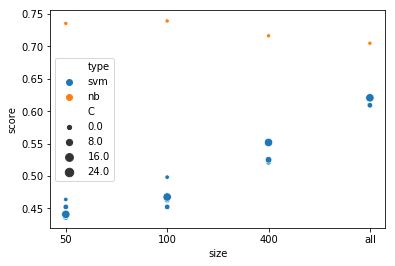

In [6]:
results_df = pd.DataFrame(models).fillna(0)
sns.scatterplot(x='size',y='score',hue='type',size = 'C',data = results_df)

In [7]:
df = parse(open(f'''C:\\Users\\yifta\\Documents\\svm_ex7\\email_train-all.txt''','rt').read())
test_df = parse(open('C:\\Users\\yifta\\Documents\\svm_ex7\\email_test.txt','rt').read())
y_test= test_df.iloc[:,0]
x_test = test_df.iloc[:,1:]
trials = 100
models = []
for sample_size in np.linspace(0.1,1,19):
    #average over 5 samples
    for c in [1,2,5,10,100]:
        score = 0
        for i in range(trials):
            train_df = df.sample(frac = sample_size)
            x_train = train_df.iloc[:,1:]
            y_train = train_df.iloc[:,0]
            clf = svm.SVC(C=c)
            clf.fit(x_train,y_train)
            score += accuracy_score(y_pred = clf.predict(x_test),y_true = y_test)
        score = score/trials
        models.append({'size':train_df.shape[0],'score':score,'C':c})
        

## its hard to draw conclusion about the c: it looks like bigger C perform better on every data size ( too big (100) varies too much).  

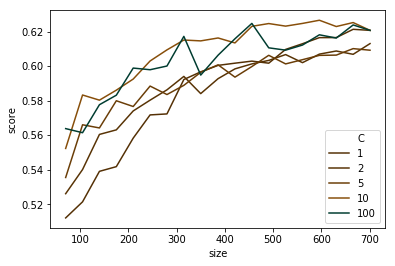

In [32]:
results_df = pd.DataFrame(models)
results_df = results_df[results_df.C.isin([1,2,5,10,100])].astype({'C':'category'})
sns.lineplot(x='size',y='score',hue='C',hue_order=[100,5,1,10,2],data = results_df,legend = 'full',palette = 'BrBG')

# this is the function for multip, but i doesnt work on jupyter

In [9]:
def get_score_for_sample(args:dict) -> pd.DataFrame:
    trials = args['trials']
    models = []
    print('here')
    for c in args['c_list']:
        score = 0
        for i in range(trials):
            train_df = args['df'].sample(frac = args['size'])
            x_train = train_df.iloc[:,1:]
            y_train = train_df.iloc[:,0]
            clf = svm.SVC(C=args['C'])
            clf.fit(x_train,y_train)
            score += accuracy_score(y_pred = clf.predict(args['x_test']),y_true = args['y_test'])
        score = score/trials
        models.append({'C':args['C'],'score':score,'size':train_df.shape[0]})
    print('done')
    return models